In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from numba import cuda

%matplotlib inline

tf.keras.backend.clear_session()

In [7]:
data_dir = '../data/rock-paper-scissors/'

In [2]:
import os

if not os.path.exists('../data/rock-paper-scissors/Training'):
    os.mkdir('../data/rock-paper-scissors/Training')
if not os.path.exists('../data/rock-paper-scissors/Validation'):
    os.mkdir('../data/rock-paper-scissors/Validation')

In [3]:
from shutil import copyfile
def split_images(SRC,SRC_TRAIN,SRC_VALID,SPLIT):
    images = os.listdir(SRC)
    
    train_split = int(len(images) * SPLIT)
    valid_split = int( len(images) - train_split )
    
    train_cnt = 0
    valid_cnt = 0
    
    for cnt in range(train_split):
        choice = random.choice(images)
        copyfile(SRC+choice,SRC_TRAIN+choice)
        images.remove(choice)
        train_cnt += 1
    
    for cnt in range(valid_split):
        choice = random.choice(images)
        copyfile(SRC+choice,SRC_VALID+choice)
        images.remove(choice)
        valid_cnt += 1
        
    print("Train Count : "+str(train_cnt))
    print("Valid Count : "+str(valid_cnt))
    

In [7]:
if not os.path.exists('../data/rock-paper-scissors/Training/rock/'):
    os.mkdir('../data/rock-paper-scissors/Training/rock/')
if not os.path.exists('../data/rock-paper-scissors/Training/paper/'):
    os.mkdir('../data/rock-paper-scissors/Training/paper/')
if not os.path.exists('../data/rock-paper-scissors/Training/scissors/'):
    os.mkdir('../data/rock-paper-scissors/Training/scissors/')
if not os.path.exists('../data/rock-paper-scissors/Validation/rock/'):
    os.mkdir('../data/rock-paper-scissors/Validation/rock/')
if not os.path.exists('../data/rock-paper-scissors/Validation/paper/'):
    os.mkdir('../data/rock-paper-scissors/Validation/paper/')
if not os.path.exists('../data/rock-paper-scissors/Validation/scissors/'):
    os.mkdir('../data/rock-paper-scissors/Validation/scissors/')

In [8]:
train_dir = '../data/rock-paper-scissors/Training/'
valid_dir = '../data/rock-paper-scissors/Validation/'

rocks_dir = '../data/rock-paper-scissors/rock/'
paper_dir = '../data/rock-paper-scissors/paper/'
scissors_dir = '../data/rock-paper-scissors/scissors/'

rock_train = '../data/rock-paper-scissors/Training/rock/'
paper_train = '../data/rock-paper-scissors/Training/paper/'
scissors_train = '../data/rock-paper-scissors/Training/scissors/'

rock_valid = '../data/rock-paper-scissors/Validation/rock/'
paper_valid = '../data/rock-paper-scissors/Validation/paper/'
scissors_valid = '../data/rock-paper-scissors/Validation/scissors/'

In [9]:
split_images(rocks_dir,rock_train,rock_valid,0.7)
split_images(paper_dir,paper_train,paper_valid,0.7)
split_images(scissors_dir,scissors_train,scissors_valid,0.7)

Train Count : 508
Valid Count : 218
Train Count : 498
Valid Count : 214
Train Count : 525
Valid Count : 225


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=90,
                                  shear_range=0.2,
                                  fill_mode='nearest',
                                  width_shift_range=0.2)

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [12]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150,150),
                                                   class_mode = 'categorical',
                                                   batch_size = batch_size)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150,150),
                                                   class_mode = 'categorical',
                                                   batch_size = batch_size)

Found 1531 images belonging to 3 classes.
Found 657 images belonging to 3 classes.


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(2,2),activation='relu',input_shape=(150,150,3)),  #149x149
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),                          #147x147
    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),                          #145x145
    tf.keras.layers.MaxPooling2D(2,2),                                           #72x72
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(2,2),activation='relu'),                          #71x71
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),                          #69x69
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),                          #67x67
    tf.keras.layers.MaxPooling2D(2,2),                                           #33x33
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(2,2),activation='relu'),                          #32x32
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),                          #30x30
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),                          #28x28
    tf.keras.layers.MaxPooling2D(2,2),                                           #14x14
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),                          #12x12
    tf.keras.layers.MaxPooling2D(2,2),                                           #6x6
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 149, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 72, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 32)        2080      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 32)        9

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epochs,logs):
        if logs.get('val_acc') > 0.97:
            print("Reached 97% Validation Accuracy so cancelling training!")
            self.model.stop_training =True

In [16]:
callbacks = MyCallback()

In [18]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=int(1531/batch_size),
                              epochs = 30,
                             callbacks=[callbacks],
                             validation_steps=int(657/batch_size))

Epoch 1/30
95/95 [==============================] - 18s 185ms/step - loss: 0.5365 - acc: 0.8040 - val_loss: 2.0544 - val_acc: 0.3323
Epoch 2/30
95/95 [==============================] - 22s 227ms/step - loss: 0.3799 - acc: 0.8634 - val_loss: 1.4077 - val_acc: 0.3338
Epoch 3/30
95/95 [==============================] - 34s 361ms/step - loss: 0.2744 - acc: 0.9023 - val_loss: 1.2370 - val_acc: 0.5000
Epoch 4/30
95/95 [==============================] - 37s 386ms/step - loss: 0.2693 - acc: 0.9083 - val_loss: 0.2026 - val_acc: 0.9192
Epoch 5/30
95/95 [==============================] - 41s 428ms/step - loss: 0.1806 - acc: 0.9538 - val_loss: 0.3116 - val_acc: 0.8841
Epoch 6/30
95/95 [==============================] - 41s 429ms/step - loss: 0.1361 - acc: 0.9584 - val_loss: 0.6492 - val_acc: 0.8034
Epoch 7/30
95/95 [==============================] - 41s 428ms/step - loss: 0.1356 - acc: 0.9578 - val_loss: 0.0466 - val_acc: 0.9802


In [19]:
model.evaluate_generator(valid_generator,steps=int(657/batch_size))

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.04661061242222786, 0.980182945728302]

Text(0.5, 1.0, 'Training vs Validation Accuracy')

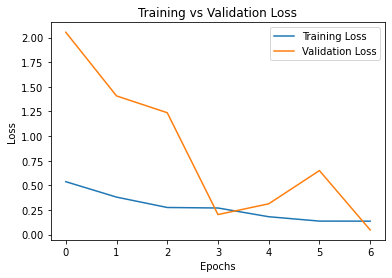

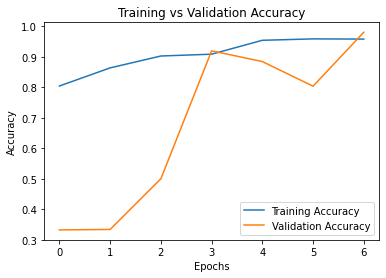

In [21]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss','Validation Loss'])
plt.title('Training vs Validation Loss')

plt.figure()
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Training vs Validation Accuracy')



In [34]:
label_map = (train_generator.class_indices)
print(label_map)

{'paper': 0, 'rock': 1, 'scissors': 2}


In [41]:
cuda.close()